In [7]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV
from pyrecorder.recorder import Recorder
from pyrecorder.writers.video import Video
from pymoo.visualization.fitness_landscape import FitnessLandscape
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.core.callback import Callback
from pyrecorder.writers.streamer import Streamer
from pymoo.visualization.pcp import PCP

In [3]:
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.rec = Recorder(Streamer(sleep=0.1))

    def notify(self, algorithm):
        problem = algorithm.problem

        pcp = PCP(title=("Gen %s" % algorithm.n_gen, {'pad': 30}),
                  bounds=(problem.xl, problem.xu),
                  labels=["$x_%s$" % k for k in range(problem.n_var)]
                  )
        pcp.set_axis_style(color="grey", alpha=0.5)

        pcp.add(algorithm.pop.get("X"), color="black", alpha=0.8, linewidth=1.5)
        if algorithm.off is not None:
            pcp.add(algorithm.off.get("X"), color="blue", alpha=0.8, linewidth=0.5)

        pcp.add(algorithm.opt.get("X"), color="red", linewidth=4)
        pcp.do()

        self.rec.record()


PSO:Best solution found: 
X = [ 2.33118727  1.93772922 -0.51280698  4.40246751 -0.63569566  1.00838543
  1.59181752]
F = [680.66793474]
Threads: 3.9317283630371094
GD 1796.956750410436
IGD 1796.956750410436
HV 0.0


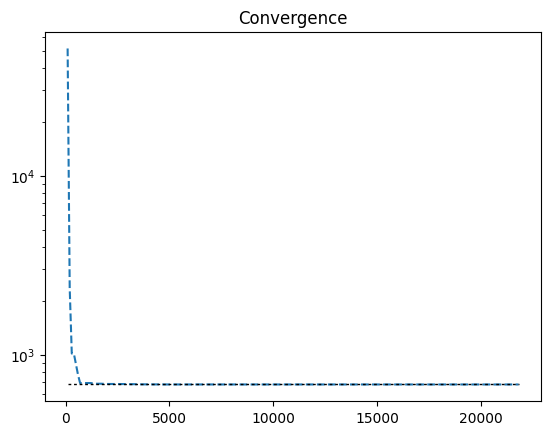

In [13]:

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems.single import Rastrigin

problem = get_problem("G9")


algorithm = PSO(pop_size=100)

res = minimize(problem,
               algorithm,
               seed=1,
               save_history=True,
               verbose=False)

print("PSO:Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
print('Threads:', res.exec_time)

pf = problem.pareto_front()
ind = GD(pf)
print("GD", ind(res.X))
ind2 = IGD(pf)
print("IGD", ind2(res.X))
ref_point = np.array([1.2, 1.2])
HV_ind = HV(ref_point=ref_point)
print("HV", HV_ind(res.X))

n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
plt.yscale("log")
plt.show()

GA:Best solution found: 
X = [ 2.17030894  1.93808828 -0.48269468  4.43805189 -0.61000311  1.133654
  1.46967285]
F = [681.16460217]
Threads: 16.23290514945984
GD 1796.9815910474153
IGD 1796.9815910474153


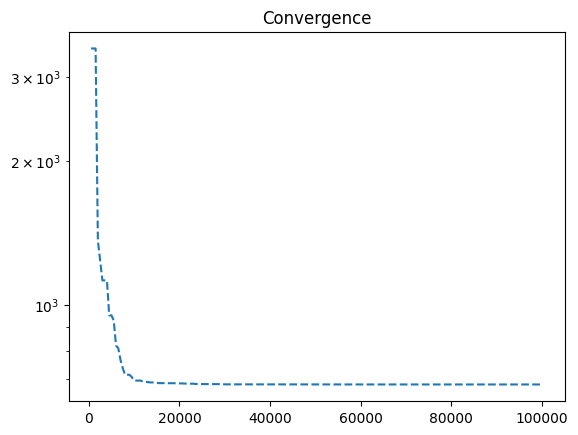

In [5]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm2 = GA(pop_size=500)

res2 = minimize(problem,
               algorithm2,
               seed=1,
               save_history=True,
               verbose=False)

print("GA:Best solution found: \nX = %s\nF = %s" % (res2.X, res2.F))
print('Threads:', res2.exec_time)


print("GD", ind(res2.X))

print("IGD", ind2(res2.X))

n_evals2 = np.array([e.evaluator.n_eval for e in res2.history])
opt2 = np.array([e.opt[0].F for e in res2.history])

plt.title("Convergence")
plt.plot(n_evals2, opt2, "--")
plt.yscale("log")
plt.show()


UNSGA3: Best solution found: 
X = [1.         1.         1.         1.         1.         1.
 1.         1.         1.         2.99048993 2.97175718 2.99255741
 1.        ]
F = [-14.95480452]
Threads: 3.062805414199829
GD 59.41694965273173
IGD 59.41694965273173


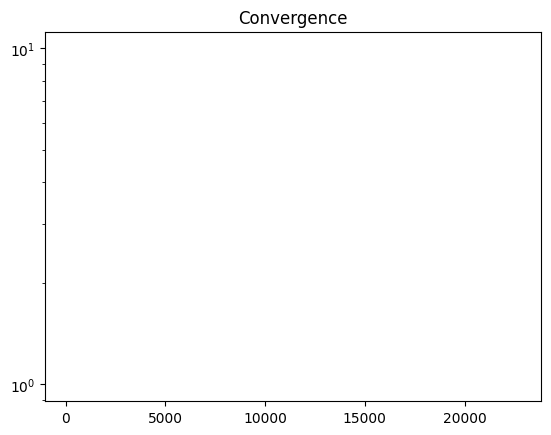

In [128]:
from pymoo.algorithms.moo.unsga3 import UNSGA3
ref_dirs = np.array([[1.0]])

# create the algorithm object
algorithm3 = UNSGA3(ref_dirs, pop_size=100)

# execute the optimization
res3 = minimize(problem,
               algorithm3,
               save_history=True,
               seed=1)

print("UNSGA3: Best solution found: \nX = %s\nF = %s" % (res3.X, res3.F))
print('Threads:', res3.exec_time)


print("GD", ind(res3.X))

print("IGD", ind2(res3.X))

n_evals3 = np.array([e.evaluator.n_eval for e in res3.history])
opt3 = np.array([e.opt[0].F for e in res3.history])

plt.title("Convergence")
plt.plot(n_evals3, opt3, "--")
plt.yscale("log")
plt.show()

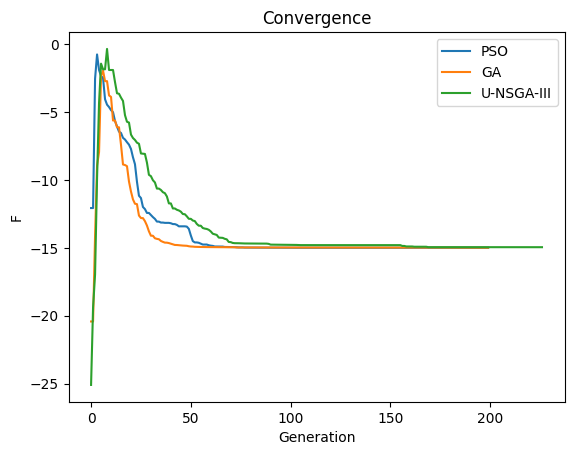

In [129]:
plt.plot(np.arange(len(res.history)), opt, label="PSO")
plt.plot(np.arange(len(res2.history)), opt2, label="GA")
plt.plot(np.arange(len(res3.history)), opt3, label="U-NSGA-III")
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("F")
plt.legend()
plt.show()

In [11]:
from pymoo.core.problem import ElementwiseProblem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
import pymoo.gradient.toolbox as anp

class MyProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=20, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = (x ** 2).sum()

# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)


res2 = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res2.exec_time)

pool.close()

print("Best solution found: \nX = %s\nF = %s" % (res2.X, res2.F))
print('Threads:', res2.exec_time)
pf = get_problem("Rastrigin").pareto_front()

ind = GD(pf)
print("GD", ind(res2.X))
ind2 = IGD(pf)
print("IGD", ind2(res2.X))

problem2 = MyProblem()
res2 = minimize(problem2, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res2.exec_time)

Threads: 1.7225711345672607
Best solution found: 
X = [-1.84454184e-03 -3.07855265e-07 -1.84083883e-03 -2.55294717e-03
  1.21220024e-04 -3.49845921e-04  1.95880478e-03  3.77647259e-03
  8.75012245e-04  6.09764405e-03  1.52411796e-03  4.16973334e-03
  2.92235697e-03 -5.93120277e-04  1.54744547e-04  3.13440708e-03
  8.93193580e-04  3.69947553e-03 -4.32435083e-03 -7.59810588e-04]
F = [0.0001417]
Threads: 1.7225711345672607
GD 0.011903885171949834
IGD 0.011903885171949834
Threads: 1.226860523223877


In [ ]:
from pymoo.core.problem import Problem
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize

class MyProblem(Problem):

    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = np.sum((x  ** 2), axis=1)

problem2 = MyProblem()

res = minimize(problem2, PSO(pop_size=3000), seed=1, verbose = True, n_gen= 100)
print('Threads:', res.exec_time)
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

In [ ]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem2(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = (x ** 2).sum()

In [ ]:

# initialize the thread pool and create the runner
n_threads = 8
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem3 = MyProblem2(elementwise_runner=runner)

res = minimize(problem3, PSO(pop_size=3000), seed=1, verbose = True,n_gen= 100)
print('Threads:', res.exec_time)
print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
pool.close()

In [ ]:
import multiprocessing
n_proccess = 8
pool = multiprocessing.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)
problem4 = MyProblem2(elementwise_runner=runner)
res = minimize(problem4, PSO(pop_size=3000), seed=1, n_gen= 100)
print('Threads:', res.exec_time)
pool.close()

In [ ]:
from dask.distributed import Client
from pymoo.core.problem import DaskParallelization
client = Client()
client.restart()
print("DASK STARTED")

# initialize the thread pool and create the runner
runner = DaskParallelization(client)


# define the problem by passing the starmap interface of the thread pool
problem5 = MyProblem2(elementwise_runner=runner)

res = minimize(problem5, PSO(pop_size=3000), seed=1, n_gen= 100)
print('Threads:', res.exec_time)

client.close()
print("DASK SHUTDOWN")

In [ ]:
from pymoo.algorithms.moo.unsga3 import UNSGA3
ref_dirs = np.array([[1.0]])

# execute the optimization
res2 = minimize(problem2,
               UNSGA3(ref_dirs, pop_size=100),
               seed=1)

print("Best solution found: \nX = %s\nF = %s" % (res2.X, res2.F))
print('Threads:', res2.exec_time)
pf = get_problem("Rastrigin").pareto_front()

ind = GD(pf)
print("GD", ind(res2.X))
ind2 = IGD(pf)
print("IGD", ind2(res2.X))
